# SVM Weights and Support Vector Analysis

In [94]:
import numpy as np
import pandas as pd
from scipy.sparse import lil_matrix, csr_matrix,save_npz,load_npz
from sklearn import svm
from scipy.sparse import hstack
from collections import defaultdict
import json 
from scipy import sparse
from scipy.sparse import rand
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix, vstack
import scipy.stats as stats
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

In [95]:
#Read in the data 
df = pd.read_csv('Matrix_Data/training_labels_2.csv')
type_dic = df.to_dict()

In [96]:
#Switch Keys and values in dictionary
with open('Matrix_Data/apps_2.json') as f:
    apps = json.load(f)
    
apps_swap = {y:x for x,y in apps.items()}

In [97]:
def formatData(filepath):
    '''
    A function that formats the data of the dictionary 
    approriatly in regards to its category
    
    @param filepath: the path to read in the SVM weights from 
    @returns: a new dictionary with all weights for each coresponding category
    '''
    my_file = open(filepath, "r")
    content = my_file.read()
    content_list = content.split(',')
    num = 0 
    cat = 0
    training_apps = 1088
    li = []
    category = ['Benign', 'Adware', 'Trojan', 'Backdoor', 'Ransom']
    dic = defaultdict(list)

    for i in content_list:
        i = "{:.16f}".format(float(i))
        li.append([i, num])
        num += 1
        if num == training_apps:
            num = 0
            dic[category[cat]].append(li)
            cat += 1
            li = []
    return dic

def orderWeights(dic):
    '''
    A function that orders the weights of each catagory in reverse order
    
    @param dic: A dictionary that has coresponding weights for each category
    @returns: a new dictionary with all weights for each coresponding category sorted in reverse
    '''
    
    for cat in dic:
        dic[cat][0].sort(key=lambda x: float(x[0]), reverse=True)

    return dic

In [98]:
dataAA = formatData("AAt_SVM_Weights.txt")
dataABA = formatData("ABAt_SVM_Weights.txt")
dataAPA = formatData("APAt_SVM_Weights.txt")
dataAA = orderWeights(dataAA)
dataABA = orderWeights(dataABA)
dataAPA = orderWeights(dataAPA)

In [99]:
def importantFeatures(dic, outname):
    '''
    A function that obtains the top 5% of positive and negative SVM weights for each category
    
    @param dic: A dictionary that has coresponding weights for each category
    @param outname: The outpath for the new dictionary
    @returns: a new dictionary with the top 5% of SVM weights in sorted order by category
    '''
    mostImportant = defaultdict(lambda: defaultdict(list))
    for cat in dic:
        mostImportant[cat]['Positive'].append(dic[cat][0][:54])
        mostImportant[cat]['Negative'].append(dic[cat][0][-54:])
        
    with open(outname, 'w') as fp:
        json.dump(mostImportant, fp)
        
    return mostImportant

Top_dataAA = importantFeatures(dataAA, 'Top_AA_Weights.json')
Top_dataABA = importantFeatures(dataABA, 'Top_ABA_Weights.json')
Top_dataAPA = importantFeatures(dataAPA, 'Top_APA_Weights.json')

In [100]:
def importantFeaturesAll(dic, outname):
    '''
    A function that gets all weights for each category and sorts them by negative and positive
    
    @param outname: The outpath for the new dictionary
    @returns: a new dictionary with the top 5% of SVM weights in sorted order by category
    '''
    mostImportant = defaultdict(lambda: defaultdict(list))
    for cat in dic:
        for i in range(len(dic[cat][0])):
            if float(dic[cat][0][i][0]) > 0:   
                mostImportant[cat]['Positive'].append(dic[cat][0][i])
            elif float(dic[cat][0][i][0]) < 0:
                mostImportant[cat]['Negative'].append(dic[cat][0][i])
        
    with open(outname, 'w') as fp:
        json.dump(mostImportant, fp)
        
    return mostImportant

In [101]:
dataAAx = importantFeaturesAll(dataAA, 'AA_Weights.json')
dataABAx = importantFeaturesAll(dataABA, 'ABA_Weights.json')
dataAPAx = importantFeaturesAll(dataAPA, 'APA_Weights.json')

In [102]:
def convertDic(dic, type_dic):
    '''
    A function that gets all weights for each category and converts the index of an app (vector)
    to be a cateogry positive
    
    @param dic: The outpath for the new dictionary
    @param type_dic: A dictionary with the type (category) coresponding to each app index for a given weight 
    @returns: a new dictionary with the cateogry each vector belongs to. This will be useful for creating the 
    viz of positive weights and the vecotr(app) categories
    '''
    dict1 = dict(dic)
    for cat in dict1:
        for label in dict1[cat]:
            for li in dict1[cat][label]:
                li[1] = type_dic["0"][li[1]]

    return dict1

swap_dic = convertDic(dataAPAx, type_dic)

In [103]:
def create_df(dic):
    '''
    A function to preform basic EDA on the distribution of positive support vectors in a specific 
    category
    
    @param dic: A dictionary of values that contain a category and their coresponding weights and type
    @returns: a dataframe containing distribution of positive weights for a decision boundry of a particular type
    '''
    Benign_df = pd.DataFrame.from_dict(dic['Benign']['Positive'][0])
    Adware_df = pd.DataFrame.from_dict(dic['Adware']['Positive'][0])
    Trojan_df = pd.DataFrame.from_dict(dic['Trojan']['Positive'][0])
    Backdoor_df = pd.DataFrame.from_dict(dic['Backdoor']['Positive'][0])
    Ransom_df = pd.DataFrame.from_dict(dic['Ransom']['Positive'][0])

    Benign_df.columns = ['Values', 'Benign']
    Adware_df.columns = ['Values', 'Adware']
    Trojan_df.columns = ['Values', 'Trojan']
    Backdoor_df.columns = ['Values', 'Backdoor']
    Ransom_df.columns = ['Values', 'Ransom']
    
    Benign_df = Benign_df.drop('Values', axis=1)
    Adware_df = Adware_df.drop('Values', axis=1)
    Trojan_df = Trojan_df.drop('Values', axis=1)
    Backdoor_df = Backdoor_df.drop('Values', axis=1)
    Ransom_df = Ransom_df.drop('Values', axis=1)
    
    df = pd.concat([Benign_df, Adware_df, Trojan_df, Backdoor_df, Ransom_df], axis = 1)
    return df


def cat_chart(dic, cat):
    '''
    Obtains only positive weights for a given cateogry and gets their values 
    
    @params dic: A dictionary with support vectors
    @params cat:a Category (i.e. trojan)
    @returns: A df contianing the values and categories for distribution of weights for a category
    '''
    
    df = pd.DataFrame.from_dict(dic[cat]['Positive'])
    df.columns = ['Values', cat]
    
    return df




In [104]:
df_Benign = cat_chart(dataAPAx, "Benign")
df_Benign['Values'] = df_Benign['Values'].astype(float)
df_Benign = df_Benign.groupby(['Benign']).sum()
df_Benign

,Values
Benign,
0,0.004172
1,0.000878
2,0.000765
3,0.000551
4,0.000076


In [105]:
df_Adware = cat_chart(dataAPAx, "Adware")
df_Adware['Values'] = df_Adware['Values'].astype(float)
df_Adware = df_Adware.groupby(['Adware']).sum()
df_Adware

,Values
Adware,
0,0.002497
1,0.010565
2,0.000828
3,0.000424
4,0.000015


In [106]:
df_Trojan = cat_chart(dataAPAx, "Trojan")
df_Trojan['Values'] = df_Trojan['Values'].astype(float)
df_Trojan = df_Trojan.groupby(['Trojan']).sum()
df_Trojan

,Values
Trojan,
0,0.003289
1,0.002246
2,0.012928
3,0.000856
4,0.000202


In [107]:
df_Back = cat_chart(dataAPAx, "Backdoor")
df_Back['Values'] = df_Back['Values'].astype(float)
df_Back = df_Back.groupby(['Backdoor']).sum()
df_Back

,Values
Backdoor,
0,0.002627
1,0.001229
2,0.000775
3,0.009243
4,0.000037


In [108]:
df_Ran = cat_chart(dataAPAx, "Ransom")
df_Ran['Values'] = df_Ran['Values'].astype(float)
df_Ran = df_Ran.groupby(['Ransom']).sum()
df_Ran

,Values
Ransom,
0,0.001736
1,0.002420
2,0.001497
3,0.001039
4,0.010446


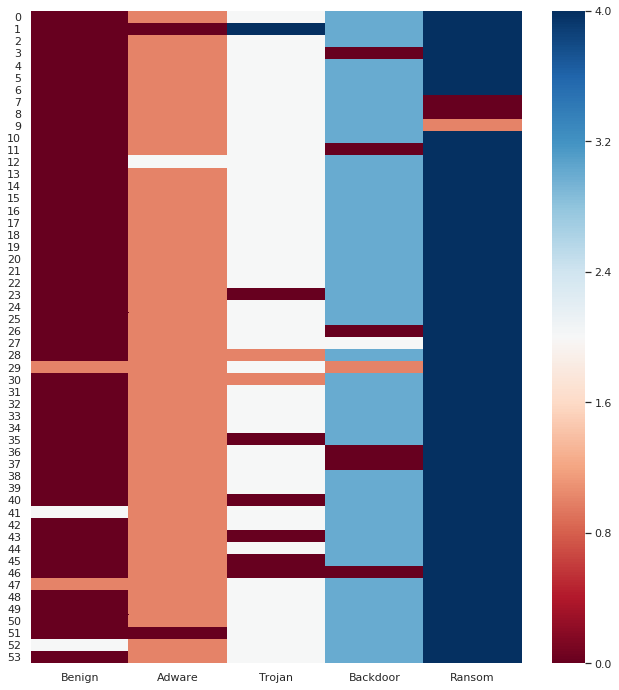

In [109]:
#Create a viz showing the positive support vector types for a given category (Weights at the top 
#have more say on the positive side) 
df = create_df(Top_dataAPA)
plt.figure(figsize=(11, 12))
sns.heatmap(df, cmap="RdBu")
sns.set(font_scale=1)

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() 
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t)
plt.show()

In [110]:
df = pd.read_json('180/Matrix_data/Heat_Percent.json', orient='columns').round(2).transpose()
df = df.rename(columns={0: 'Benign', 1: 'Adware', 2: 'Trojan', 3: 'Backdoor', 4: 'Ransom'})

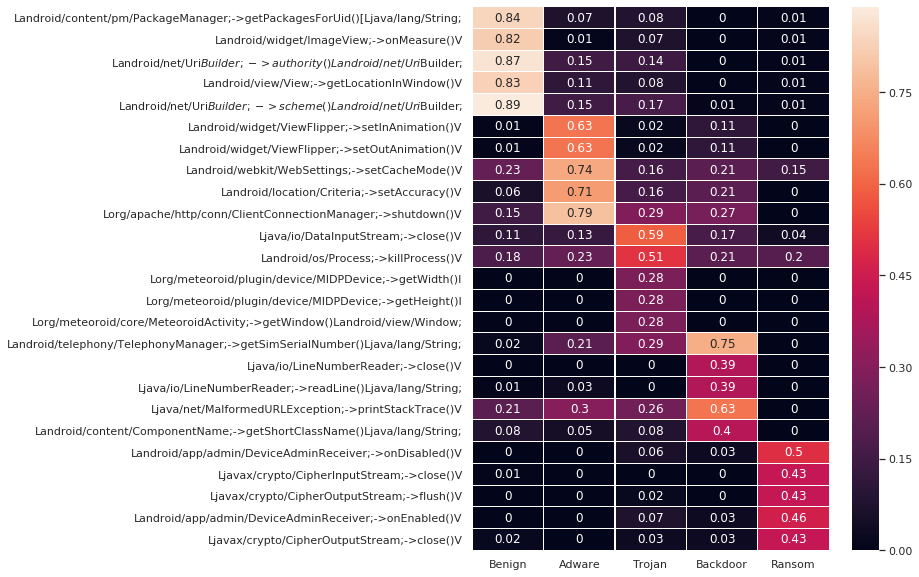

In [112]:
#Display top 5 APIs from Ranking Algorithim

plt.figure(figsize=(8, 10))
ax = sns.heatmap(df, annot=True, linewidths=.1)
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()
